##Motivation

The authors of the paper "Attention is all you need" developed the Transformer to address the limitations of previous sequence models, such as RNNs and LSTMs, which process tokens sequentially and struggle with long-range dependencies, slow training, and limited parallelization. The transformer model can capture relationships between words regardless of distance in the sequence, while being faster to train on modern hardware. By replacing recurrence with the self-attention mechanism, the Transformer allows each token to directly attend to all others in the sequence in parallel, enabling better handling of global context and much greater efficiency. This design dramatically improved performance on machine translation while reducing training time, motivating its adoption as a new standard for sequence modelling. The following Google Colab notebook is a brief review of the theory discussed in the paper and an implementation of the transformer from scratch solely using PyTorch.

**Paper: https://arxiv.org/pdf/1706.03762**

Transformer Architecture:

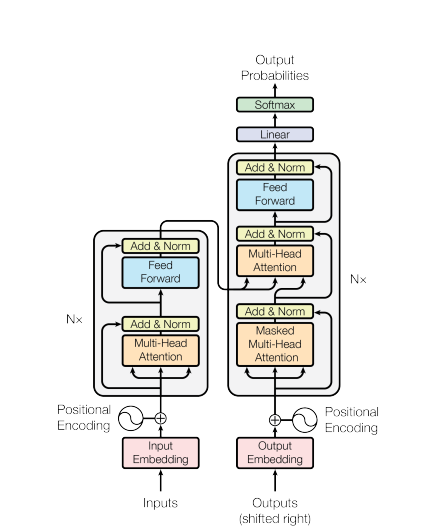

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

##Scaled Dot-Product Attention

**Reference: Section 3.2.1 "Scaled Dot-Product Attention"**

Attentio is computed on queries *Q*, keys *K*, and Values *V*   via the softmax function

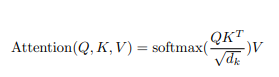

Here d$_k$ represents the dimension of the key vectors and division by
$$ \sqrt{d_k} $$
is used to prevent the dot products from becoming too large and stablizing gradients

In [ ]:
def scaled_dot_product_attention(Q, K, V, mask=None):
  d_k = Q.size()[-1]
  scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
  if mask is not None:
    scores = scores.masked_fill(mask == 0, float('-inf'))

  attention_weights = F.softmax(scores, dim=-1)
  output = torch.matmul(attention_weights, V)
  return output, attention_weights

Here we compute *QK*$^{T}$ scaled by the square root of $d_k$. We also add a mask to prevent attending to padding tokens or future tokens.

Finally we apply softmax to get the weights and multiply those weights by *V* to get the weighted sum of values

##Multi-Head Attention

**Reference: Section 3.2.2 "Multi-Head Attention"**

Each word vector is split into vectors *Q*, *V*, and *K*. These vectors are then further broken down into heads on which we perform scaled dot-product attention on each head. Finally we concatenate heads and project the output back

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()

    assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

    self.d_model = d_model
    self.num_heads = num_heads
    self.d_k = d_model // num_heads

    #linear projections
    self.W_q = nn.Linear(d_model, d_model)
    self.W_k = nn.Linear(d_model, d_model)
    self.W_v = nn.Linear(d_model, d_model)
    self.W_o = nn.Linear(d_model, d_model)

  def forward(self, Q, K, V, mask=None):
    batch_size = Q.size(0)

    #apply linear projections
    Q = self.W_q(Q)
    K = self.W_k(K)
    V = self.W_v(V)

    #split the linear projections into multiple heads
    #we will then transpose them to (batch, heads, seq_len, d_k)
    Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
    K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
    V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

    #compute scaled dot-product attention
    output, attention_weights = scaled_dot_product_attention(Q, K, V, mask)

    #concatenate the heads
    output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

    #apply final linear projection
    output = self.W_o(output)

    return output, attention_weights

##Positional Encoding

The position of a word is crucial to understanding its meaning. For instance the phrases:

"The food was not inadequate, but great"

"The food was not great, but inadequate"

contain the same words but in different positions yielding different meanings (one positive, one negative).

Hence, we add position info to embeddings with the use of sinusoids.

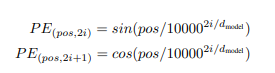

pos represents the position of the word in the sequence, $d_{model}$ represents the embedding length, and i represents the index of the embedding.

**Why sinusodial functions?**

1. Periodicity: Allows the model to understand relative distances between tokens

2. Constraints: Sin and Cos allow the values to be bounded (-1,1)

3. Makes extrapolation for long sequences much easier

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
      seq_len = x.size(1)
      return x + self.pe[:, :seq_len, :].to(x.device)



##Position-wise Feed Forward Network



**Reference: Section 3.3 "Position-wise Feed-Forward Networks"**

Each encoder and decoder layer has a fully connected feed-forward network in addition to attention sub-layers. These fully connected feed-forward networks are applied to each position independently and identically. This is made up of two linear transformations separated by a ReLU activation.




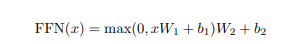

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, d_model, d_ff, dropout=0.1):
    super().__init__()
    self.linear1 = nn.Linear(d_model, d_ff)
    self.dropout = nn.Dropout(dropout)
    self.linear2 = nn.Linear(d_ff, d_model)

  def forward(self, x):
    return self.linear2(self.dropout(F.relu(self.linear1(x))))

##Encoder Layer

**Reference: Section 3.1 "Encoder and Decoder Stacks"**

Each layer consists of a:
- Multi-head self attention Add & Norm
- Feed-forward network and Add & Norm

Add & Norm Layer:
- The Add layer helps facilitate signal propagation which addresses the issue of vanishing gradients
- The Norm Layer (Layer Normalization) normalies the output across the features to adress internal covariate shift


In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        #Multi-head attention sublayer
        attn_output, _ = self.mha(x, x, x, mask) # Unpack the tuple, take only the output
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)

        #Feedforward sublayer
        ff_output = self.ff(x)
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)

        return x

##Decoder Layer

- Masked multi-head self-attention + Add & Norm
- Encoder-decoder multi-head attention + Add & Norm
- Feed-forward + Add & Norm

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
    super().__init__()
    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)
    self.ff = FeedForward(d_model, d_ff, dropout)

    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.norm3 = nn.LayerNorm(d_model)

    self.dropout1 = nn.Dropout(dropout)
    self.dropout2 = nn.Dropout(dropout)
    self.dropout3 = nn.Dropout(dropout)

  def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
    # x has shape (batch_size, tgt_len, d_model)
    # encoder_output has shape (batch_size, src_len, d_model)

    # Masked multi-head self-attention
    # Q, K, V are all x
    attn1_output, _ = self.mha1(x, x, x, tgt_mask) # tgt_mask should have shape (batch_size, 1, tgt_len, tgt_len) or (batch_size, 1, 1, tgt_len)
    x = self.norm1(x + self.dropout1(attn1_output))

    # Encoder-decoder multi-head attention
    # Q is x, K and V are encoder_output
    # src_mask should have shape (batch_size, 1, 1, src_len)
    attn2_output, _ = self.mha2(x, encoder_output, encoder_output, src_mask)
    x = self.norm2(x + self.dropout2(attn2_output))

    # Feedforward
    ff_output = self.ff(x)
    x = self.norm3(x + self.dropout3(ff_output))

    return x

##Full Encoder

We now use the layers we created to develop the entire encoder stack

In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, input_vocab_size, max_seq_len, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_len)

        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x, mask)

        return x


##Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, target_vocab_size, max_seq_len, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = nn.Embedding(target_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_len)

        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x, enc_output, src_mask, tgt_mask)
        return x


##Transformer

In [ ]:
import torch.nn as nn

class Transformer(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff,
                 input_vocab_size, target_vocab_size,
                 max_seq_len_input, max_seq_len_target, dropout=0.1):
        super().__init__()

        self.d_model = d_model # Store d_model as an instance attribute

        self.encoder = Encoder(num_layers, d_model, num_heads, d_ff, input_vocab_size, max_seq_len_input, dropout)
        self.decoder = Decoder(num_layers, d_model, num_heads, d_ff, target_vocab_size, max_seq_len_target, dropout)

        self.final_linear = nn.Linear(d_model, target_vocab_size)

    def make_src_mask(self, src):
        # Mask padded tokens (0 assumed as pad token)
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, src_len)
        return src_mask

    def make_tgt_mask(self, tgt):
        batch_size, tgt_len = tgt.size()

        #mask padded tokens
        tgt_pad_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)

        tgt_sub_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=tgt.device)).bool()

        tgt_mask = tgt_pad_mask & tgt_sub_mask
        return tgt_mask

    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)

        enc_output = self.encoder(src, src_mask)
        dec_output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
        output = self.final_linear(dec_output)

        return output